In [1]:
import re
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def read_bw(f):
    lines = []
    for a in f:
        if a.startswith("Starting"):
            lines.append(a.rstrip())
        elif ("Mbits/sec" in a):
            lines.append(a.strip())
    data = []
    for i in range(0, len(lines), 2):
        numbers = re.findall(r'\d+', lines[i])
        if numbers:
            numbers.append(re.findall(r'\d+', lines[i+1])[0])
            data.append(numbers)
    return data

data_sev = read_bw(open("../generator/output_snp.log", "r").readlines())
data_vanilla = read_bw(open("../generator/output_vanilla.log", "r").readlines())
data_sev_rules = read_bw(open("../generator/output_snp_rules.log", "r").readlines())
data_vanilla_rules = read_bw(open("../generator/output_vanilla_rules.log", "r").readlines())

In [3]:
def filterdata(key, num, inp_data, key2=None, num2=None):
    if key2 is not None and num2 is not None:
        keys = ['cpusnort', 'psize', 'tcpflows', 'rules', 'tput']
    else:
        keys = ['cpusnort', 'psize', 'tcpflows', 'tput']

    dict_data = [dict(zip(keys, row)) for row in inp_data]
    df = pd.DataFrame(dict_data)
    df[keys] = df[keys].apply(pd.to_numeric)
    
    df_filtered_1 = df[df['cpusnort'] == 1]
    df_filtered_1 = df_filtered_1[df_filtered_1[key] == num]

    df_filtered_2 = df[df['cpusnort'] == 2]
    df_filtered_2 = df_filtered_2[df_filtered_2[key] == num]

    if key2 is not None and num2 is not None:    
        df_filtered_1 = df_filtered_1[df_filtered_1[key2] == num2]    
        df_filtered_2 = df_filtered_2[df_filtered_2[key2] == num2]

    if key == "tcpflows":
        if key2 == "psize":
            x = np.arange(len(df_filtered_1['rules']))
            x_point = df_filtered_1['rules']
        else:
            x = np.arange(len(df_filtered_1['psize']))
            x_point = df_filtered_1['psize']
    elif key == "psize":
        x = np.arange(len(df_filtered_1['tcpflows']))    
        x_point = df_filtered_1['tcpflows']
    
    return x, x_point, df_filtered_1['tput'], df_filtered_2['tput']

In [16]:
def gambar(xlabel, ylabel, k1, v1, k2=None, v2=None):
    if k2 is not None and v2 is not None:
        x, xp, y1, y2 = filterdata(k1, v1, data_vanilla_rules, k2, v2)
        x, xp, y3, y4 = filterdata(k1, v1, data_sev_rules, k2, v2)    
    else:
        x, xp, y1, y2 = filterdata(k1, v1, data_vanilla)
        x, xp, y3, y4 = filterdata(k1, v1, data_sev)
    width = 0.12 

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - 1.5*width, y1, width, label='Vanilla 1 thread')
    rects2 = ax.bar(x - 0.5*width, y2, width, label='Vanilla 2 threads')
    rects3 = ax.bar(x + 0.5*width, y3, width, label='SEV-SNP 1 thread')
    rects4 = ax.bar(x + 1.5*width, y4, width, label='SEV-SNP 2 threads')
    
    if k2 is not None and v2 is not None:
        title = ylabel + " vs " + xlabel + " for " + k1 + "=" + str(v1) + "," + k2 + "=" + str(v2)        
    else:
        title = ylabel + " vs " + xlabel + " for " + k1 + "=" + str(v1) + ",rules=0"
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel+"(Mbps)")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(xp)
    ax.legend(loc='best', fancybox=True, framealpha=0.3)
    ax.set_ylim([0, 1800])
    fig.tight_layout()
    plt.show()

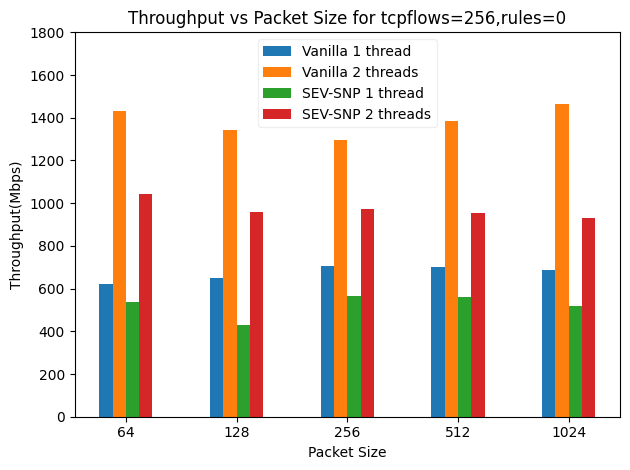

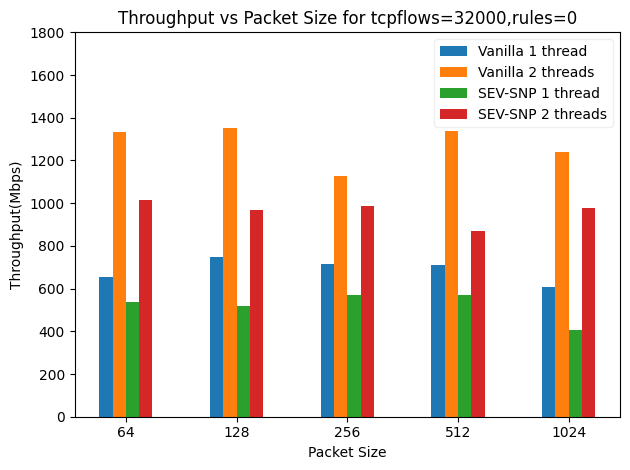

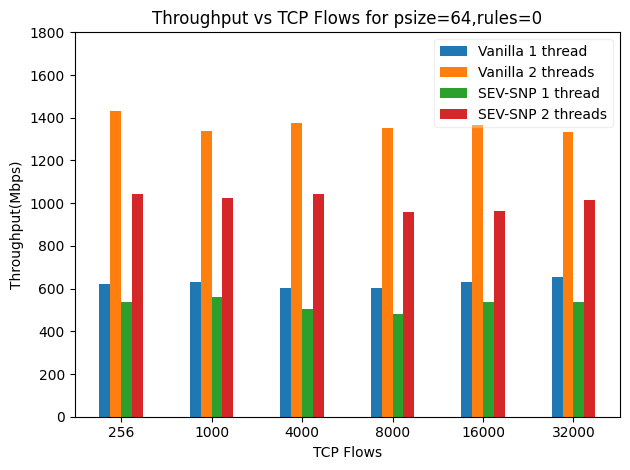

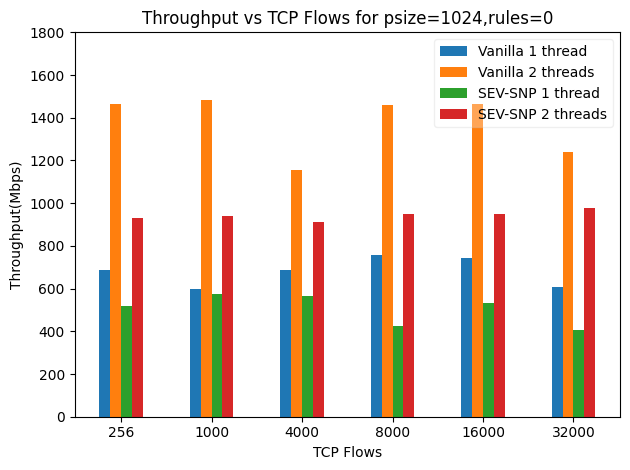

In [17]:
gambar("Packet Size", "Throughput", "tcpflows", 256)
gambar("Packet Size", "Throughput", "tcpflows", 32000)
gambar("TCP Flows", "Throughput", "psize", 64)
gambar("TCP Flows", "Throughput", "psize", 1024)

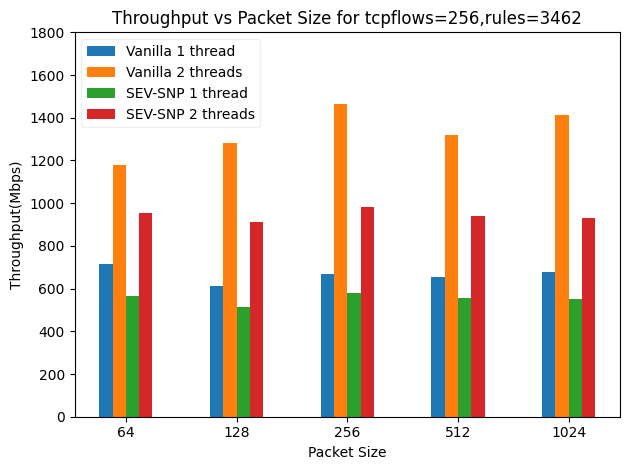

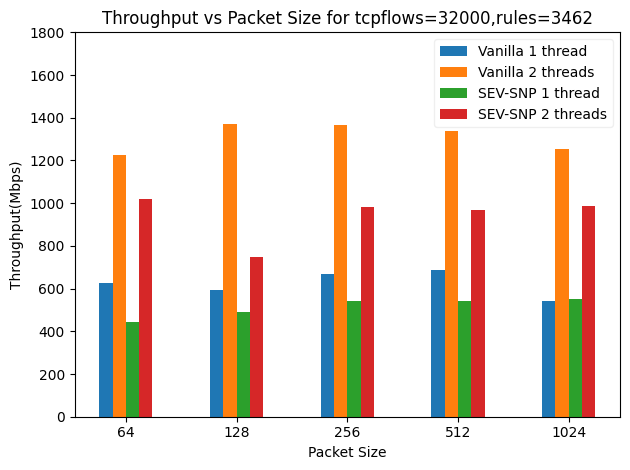

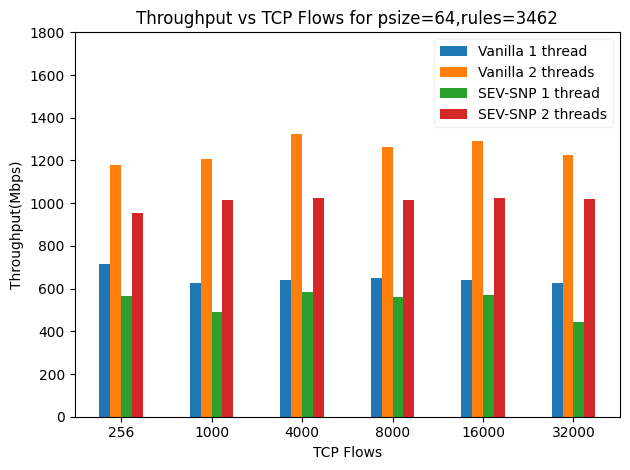

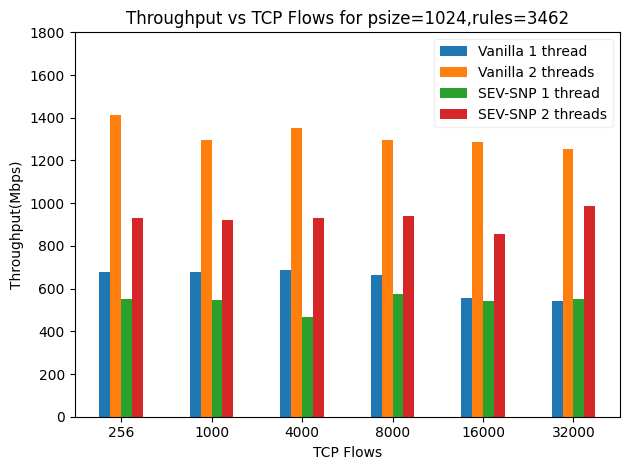

In [18]:
gambar("Packet Size", "Throughput", "tcpflows", 256, "rules", 3462)
gambar("Packet Size", "Throughput", "tcpflows", 32000, "rules", 3462)
gambar("TCP Flows", "Throughput", "psize", 64, "rules", 3462)
gambar("TCP Flows", "Throughput", "psize", 1024, "rules", 3462)

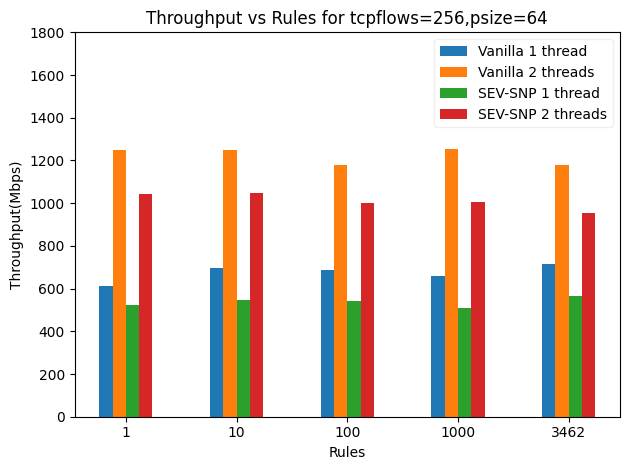

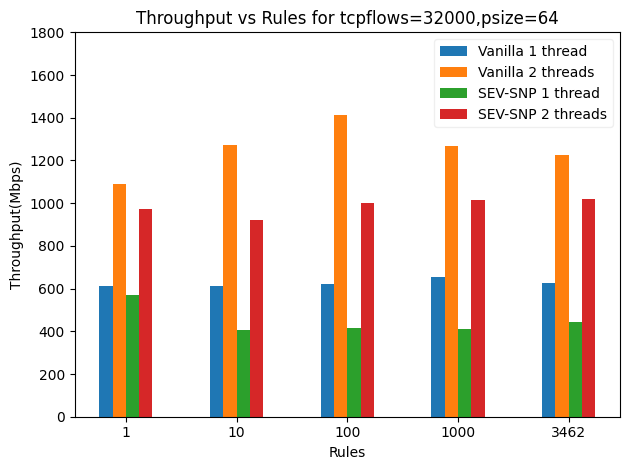

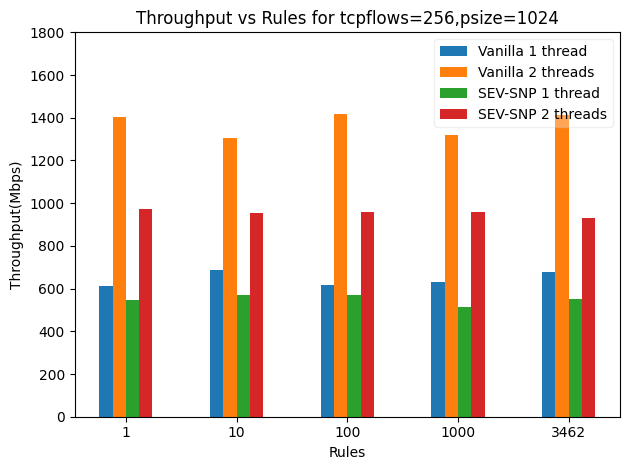

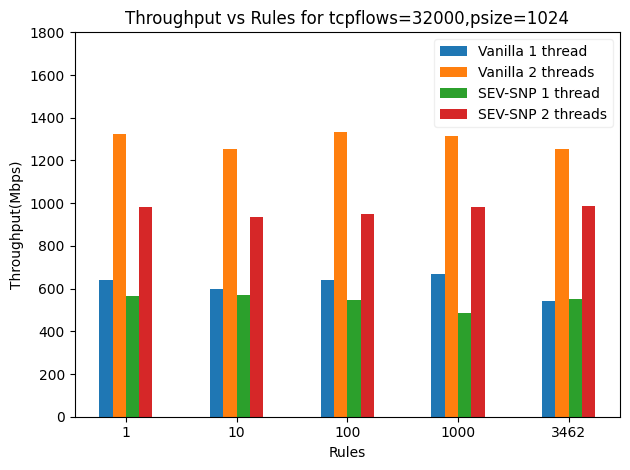

In [19]:
gambar("Rules", "Throughput", "tcpflows", 256, "psize", 64)
gambar("Rules", "Throughput", "tcpflows", 32000, "psize", 64)
gambar("Rules", "Throughput", "tcpflows", 256, "psize", 1024)
gambar("Rules", "Throughput", "tcpflows", 32000, "psize", 1024)